# Characterize FFWD NN output

In [1]:
#load libs
import keras.models

import os
import bregnn.io as io

Using TensorFlow backend.


## Read test data and model

In [2]:
# load data
base_dir = os.environ['SCRATCH'] + '/bregression'

data = io.read_data(base_dir+'/ttbar_unweighted_full80M_selected_test.hd5', columns = None )

In [3]:
# list all model files in the training folder
target = 'hybrid_cfg'
models = !ls -t $target/*.hdf5
models

['hybrid_cfg/model-19.hdf5',
 'hybrid_cfg/model-13.hdf5',
 'hybrid_cfg/model-07.hdf5',
 'hybrid_cfg/model-04.hdf5',
 'hybrid_cfg/model-03.hdf5',
 'hybrid_cfg/model-02.hdf5',
 'hybrid_cfg/model-01.hdf5']

In [4]:
# read training configuration
import json
with open('%s/config.json' % target) as fin:
    config = json.loads(fin.read())
config

{'fit_kwargs': {'batch_size': 1024, 'epochs': 20},
 'model_params': {'activations': ['lrelu',
   'lrelu',
   'lrelu',
   'lrelu',
   'lrelu',
   'lrelu',
   'lrelu',
   'lrelu'],
  'batch_norm': True,
  'const_output_biases': None,
  'do_bn0': True,
  'dropout': 0.2,
  'input_shape': [35],
  'layers': [1024, 1024, 1024, 1024, 1024, 512, 256, 128],
  'loss': 'HybridLoss',
  'loss_params': {},
  'monitor_dir': 'hybrid_cfg',
  'name': 'ffwd',
  'non_neg': False,
  'optimizer': 'Adam',
  'optimizer_params': {'lr': 0.001},
  'output_shape': None,
  'save_best_only': True,
  'valid_frac': 0.05},
 'options': {'batch_size': 1024,
  'epochs': 20,
  'features': 'Jet_pt,Jet_eta,rho,Jet_mt,Jet_leadTrackPt,Jet_leptonPtRel,Jet_leptonDeltaR,Jet_neHEF,Jet_neEmEF,Jet_vtxPt,Jet_vtxMass,Jet_vtx3dL,Jet_vtxNtrk,Jet_vtx3deL,Jet_energyRing_dR0_em_Jet_e,Jet_energyRing_dR1_em_Jet_e,Jet_energyRing_dR2_em_Jet_e,Jet_energyRing_dR3_em_Jet_e,Jet_energyRing_dR4_em_Jet_e,Jet_energyRing_dR0_neut_Jet_e,Jet_energyRing_d

## Compute predictions

In [5]:
features = config['options']['features'].split(',')

X = data[features].values
y = (data['Jet_mcPt']/data['Jet_pt']).values.reshape(-1,1)


In [7]:
model = keras.models.load_model(models[0],compile=False)

In [8]:
y_pred = model.predict(X)

## Plot raw model predictions

*Note*: the target is typically normalized in the training y = (y-mu)/sigma

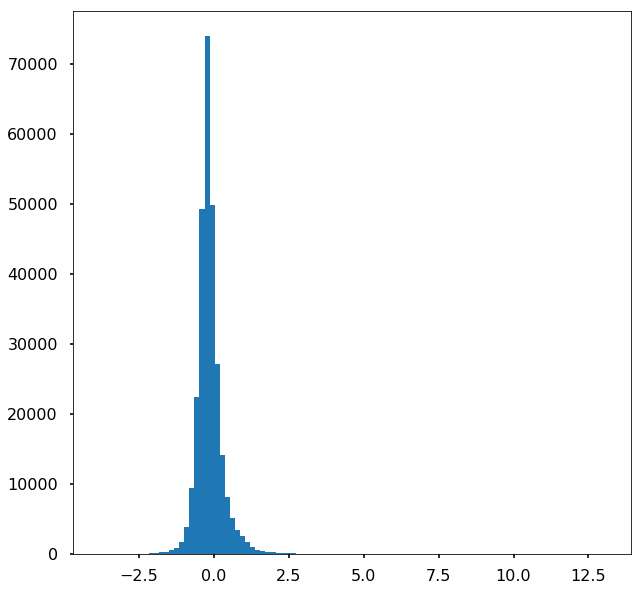

In [10]:
if y_pred.shape[1] > 1:
    plt.hist(y_pred[:,1],bins=100);

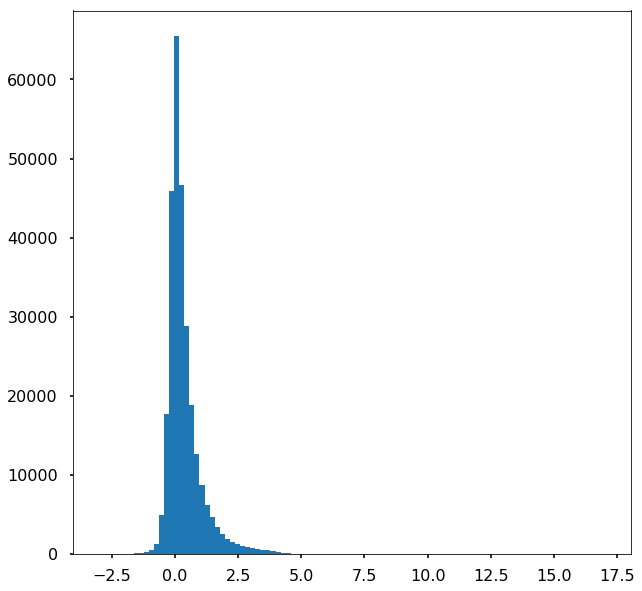

In [11]:
if y_pred.shape[1] > 2:
    plt.hist(y_pred[:,2],bins=100);

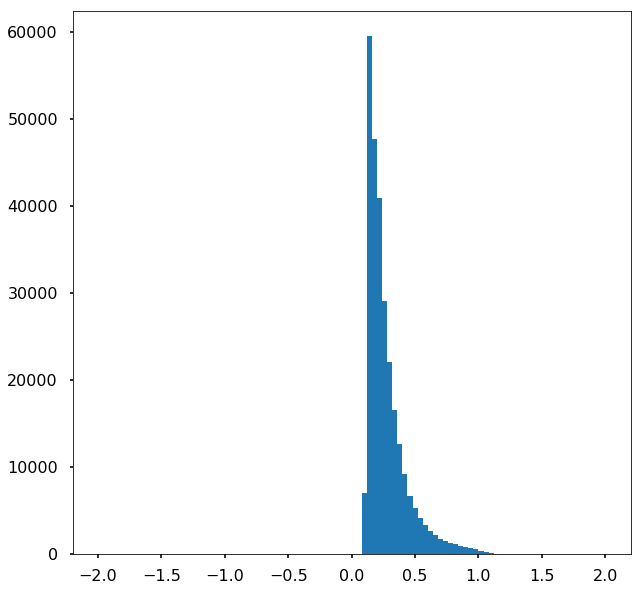

In [12]:
if y_pred.shape[1] > 2:
    plt.hist(y_pred[:,0]-y_pred[:,1],bins=100,range=[-2,2]);

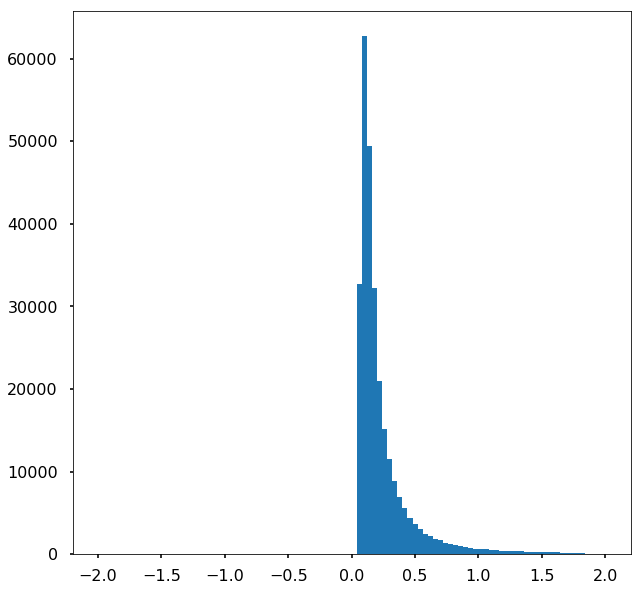

In [13]:
if y_pred.shape[1] > 2:
    plt.hist(y_pred[:,2]-y_pred[:,0],bins=100,range=[-2,2]);

## Convert raw prediction into actual scale and resolution estimation

In [9]:
if y_pred.shape[1] == 1: # with one output we only have a scale correction
    corr = y_pred
    res = None
elif y_pred.shape[1] == 2: # with two outputs first is mean and second is sigma
    corr = y_pred[:,0]
    res = y_pred[:,1]
elif y_pred.shape[1] == 3: # assume that 3 outputs are mean + 2 quantile
    corr = y_pred[:,0]
    res = 0.5*(y_pred[:,2] - y_pred[:,1])

In [14]:
# normalize back to energy scale
if config['normalize_target']:
    corr *= config['y_std']
    corr += config['y_mean']

    if res is not None:
        res *= config['y_std']

In [15]:
# errors vector
if y_pred.shape[1] > 1:
    err = y[:,0]-corr
else:
    err = y-corr

## Characterize the outcome

In [16]:
print(y.mean(),y.std())

1.07361 0.270127


In [17]:
me = err.mean()
std = err.std()
mse = np.square(err).mean()
mae = np.abs(err).mean()
print('test me ', me, ' std ', std, ' norm std ', std/config['y_std'], ' norm mse ', mse/config['y_std']**2, ' norm mae ', mae / config['y_std'])

test me  0.0206396  std  0.201856  norm std  0.739546371027  norm mse  0.552646957873  norm mae  0.350794618838


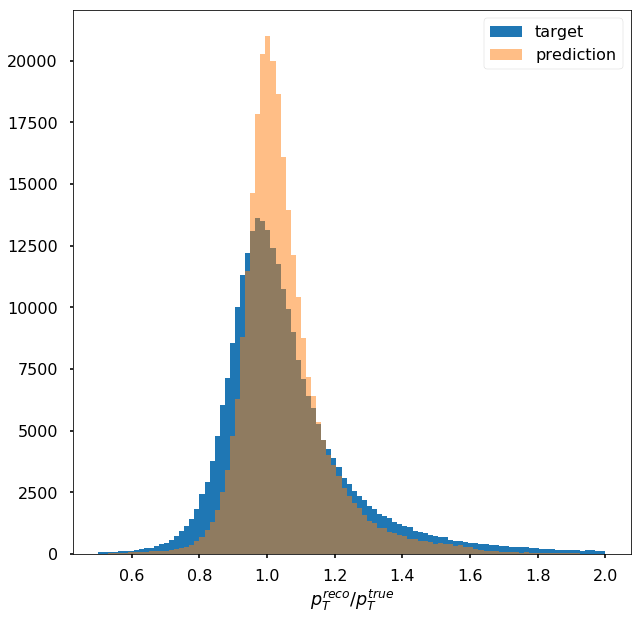

In [66]:
_,bins,_ = plt.hist(y[:,0],bins=100,range=[0.5,2],label='target');
plt.hist(y_pred[:,0],bins=bins,alpha=0.5,label='prediction');
plt.xlabel('$p_T^{reco} / p_T^{true}$')
plt.legend()

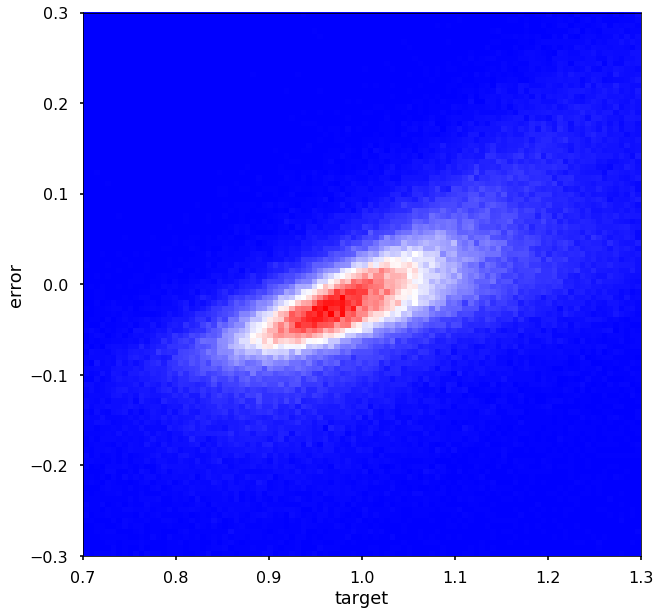

In [69]:
plt.hist2d(y.ravel(),err.ravel(),bins=100,range=[[0.7,1.3],[-0.3,0.3]]);
plt.xlabel('target')
plt.ylabel('error')

In [20]:
y [ (X[:,0] > 100 ) & (X[:,0] < 200.) ].mean()

1.0156692

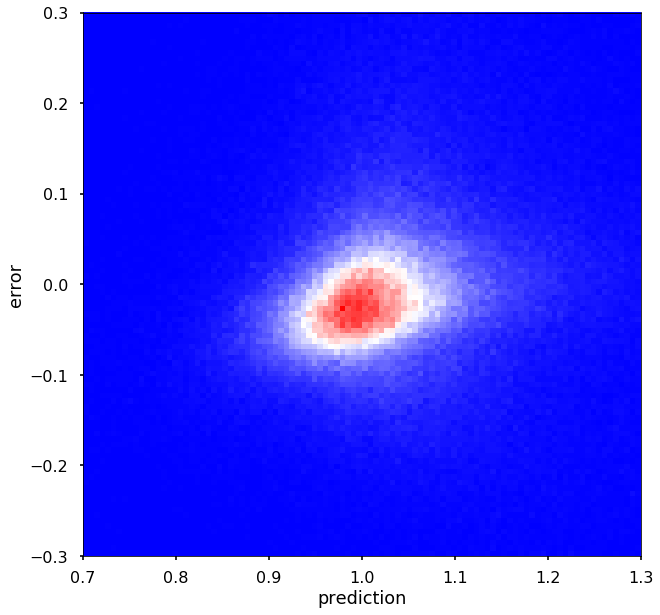

In [70]:
plt.hist2d(corr.ravel(),err.ravel(),bins=100,range=[[0.7,1.3],[-0.3,0.3]]);
plt.xlabel('prediction')
plt.ylabel('error')

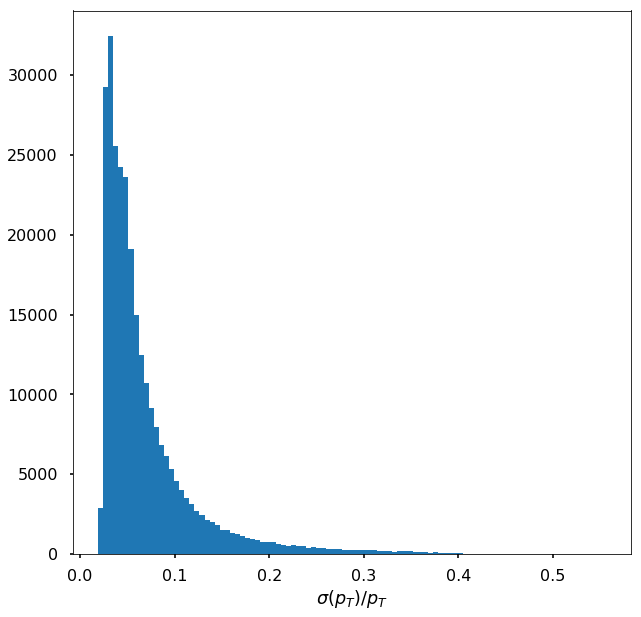

In [72]:
if res is not None:
    plt.hist(res.ravel(),bins=100)
    plt.xlabel('$\sigma(p_T) / p_T$')

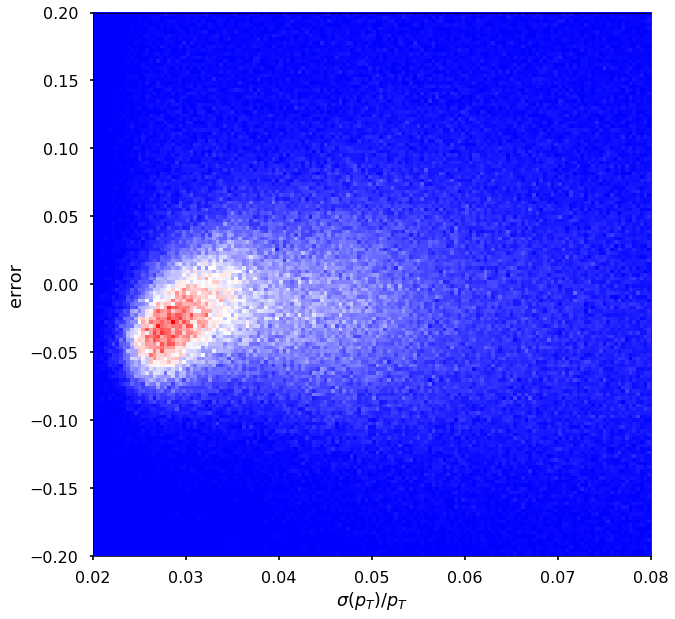

In [73]:
if res is not None:
    plt.hist2d(res.ravel(),err.ravel(),bins=150,range=[[0.02,0.08],[-0.2,0.2]]);
    plt.xlabel('$\sigma(p_T) / p_T$')
    plt.ylabel('error')

In [24]:
import bregnn.utils as utils

In [117]:
reload(utils)

bins, y_mean_pt, y_std_pt, y_qt_pt = utils.profile(y,X[:,0],range=[30,400],bins=50,uniform=False)
y_median_pt = y_qt_pt[1]
y_iqr2_pt =  y_qt_pt[0],y_qt_pt[2]

y_corr = y[:,0]/corr
_, y_corr_mean_pt, y_corr_std_pt, y_corr_qt_pt = utils.profile(y_corr,X[:,0],bins=bins) 
y_corr_median_pt = y_corr_qt_pt[1]
y_corr_iqr2_pt =  y_corr_qt_pt[0],y_corr_qt_pt[2]


(51,)
50
(51,)
50


In [118]:
print(y_corr_qt_pt.shape)

(3, 50)


In [119]:
# bins, mean, std, quantiles = pt_profile
# print(quantiles.shape)

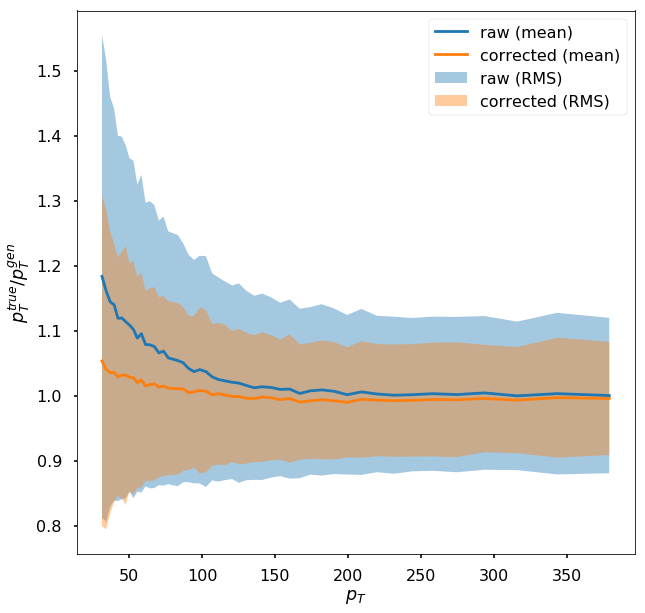

In [120]:
binc = 0.5*(bins[1:]+bins[:-1])

plt.plot(binc,y_mean_pt,label='raw (mean)')
plt.fill_between(binc,y_mean_pt-y_std_pt,y_mean_pt+y_std_pt,alpha=0.4,label='raw (RMS)')

plt.plot(binc,y_corr_mean_pt,label='corrected (mean)')
plt.fill_between(binc,y_corr_mean_pt-y_corr_std_pt,y_corr_mean_pt+y_corr_std_pt,alpha=0.4,label='corrected (RMS)')

# plt.plot(0.5*(bins[1:]+bins[:-1]),quantiles[:,0])
plt.xlabel('$p_T$')
plt.ylabel('$p_T^{true} / p_T^{gen}$')
plt.legend()

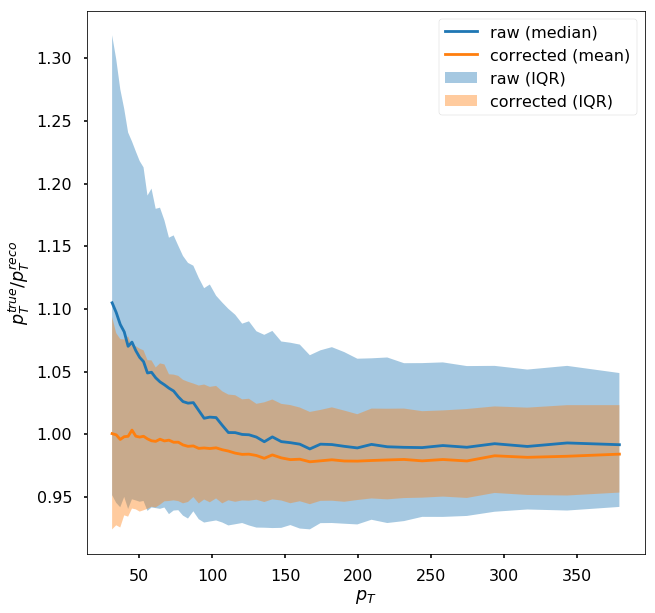

In [121]:
plt.plot(binc,y_median_pt,label='raw (median)')
plt.fill_between(binc,*y_iqr2_pt,alpha=0.4,label='raw (IQR)')

#print(y_corr_median_pt)
plt.plot(binc,y_corr_median_pt,label='corrected (mean)')
plt.fill_between(binc,*y_corr_iqr2_pt,alpha=0.4,label='corrected (IQR)')

#plt.plot(binc,y_corr_mean_pt)
#plt.fill_between(binc,y_corr_mean_pt-y_corr_std_pt,y_corr_mean_pt+y_corr_std_pt,alpha=0.4)

# plt.plot(0.5*(bins[1:]+bins[:-1]),quantiles[:,0])

plt.xlabel('$p_T$')
plt.ylabel('$p_T^{true} / p_T^{reco}$')
plt.legend()

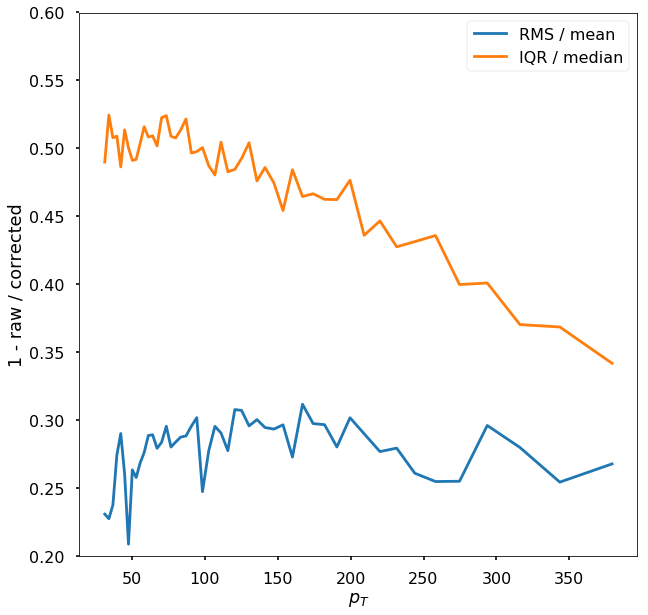

In [122]:
plt.plot(binc,1. - y_corr_std_pt / y_std_pt * y_mean_pt / y_corr_mean_pt, label='RMS / mean')
plt.plot(binc,1. - (y_corr_iqr2_pt[1]-y_corr_iqr2_pt[0]) / (y_iqr2_pt[1]-y_iqr2_pt[0]) * y_median_pt / y_corr_median_pt, label='IQR / median')
plt.ylim(0.2,0.6)

plt.xlabel('$p_T$')
plt.ylabel('1 - raw / corrected')
plt.legend()

In [123]:
if res is not None:
    res_bins, err_qt_res = utils.profile(err,res,bins=30,range=[0,0.5],moments=False) 
    print(err_qt_res.shape)
    err_iqr2 =  0.5*(err_qt_res[2]-err_qt_res[0])


(31,)
30
(3, 30)


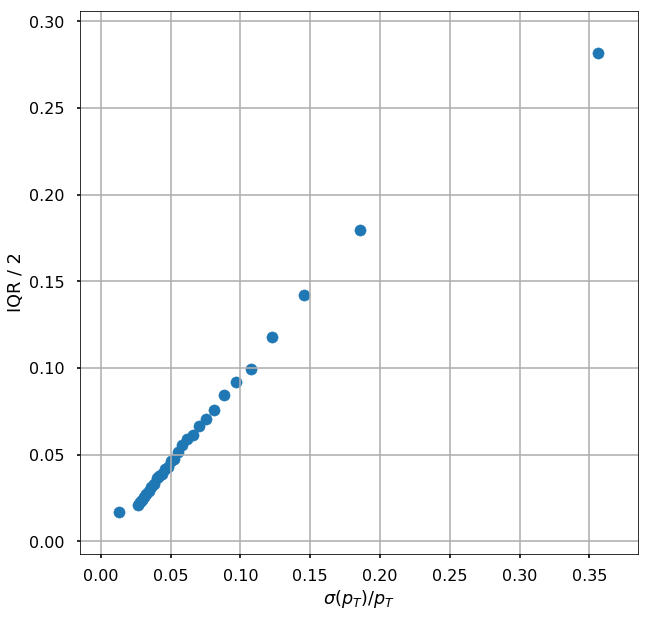

In [124]:
if res is not None:
    plt.scatter(0.5*(res_bins[1:]+res_bins[:-1]),err_iqr2)
    plt.grid()
    plt.xlabel('$\sigma(p_T)/p_T$')
    plt.ylabel('IQR / 2')